In [2]:
import abc
import astropy
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import xarray as xr

from astropy.constants import (e, k_B)
from astropy import units as u
from bapsflib import lapd
from bapsflib._hdf import File as smpd_File
from plasmapy.utils.decorators import validate_quantities
from warnings import warn
from xarray import (register_dataarray_accessor, 
                    register_dataset_accessor)

----
# Design Probe Class

In [3]:
class AbstractProbe(abc.ABC):
    """Abstrat class for defining probe characteristics/parameters."""

    
class LangmuirProbe(AbstractProbe):
    @validate_quantities
    def __init__(self, area: u.cm ** 2):
        self._area = area
    
    @property
    def area(self) -> u.cm ** 2:
        return self._area
    
    @area.setter
    @validate_quantities(value = {'can_be_negative': False,
                                  'can_be_complex': False,
                                  'none_shall_pass': False})
    def area(self, value: u.cm ** 2):
        self._area = value
        

# Design NumPy Focused Analysis Functions

1. [`find_floating_potential()`](#Define-find_floating_potential())
1. [`calc_plasma_potential()`](#Define-calc_plasma_potential())

## Define `find_floating_potential()`

Find the floating potential `Vf` from a swept langmuir trace.  This function identifies where the trace crosses `I = 0` and uses a linear regression on a select subset of data around the crossing point to determine `Vf`.

In [4]:
def find_floating_potential(voltage, current, threshold=None, pad_fit=5):
    if current.min() > 0.0 or current.max() < 0:
        warn("Sweep has no floating potential")
        return np.nan
    
    # find possible crossing points
    lower_vals = np.where(current <= 0, True, False)
    upper_vals = np.where(0 <= current, True, False)
    cp_candidates = np.logical_and(lower_vals, upper_vals).nonzero()[0]  # exact zero locations
    additional_candidates = np.logical_and(np.roll(lower_vals, 1), upper_vals).nonzero()[0]
    cp_candidates = np.concatenate((cp_candidates, additional_candidates, additional_candidates-1))
    cp_candidates = np.unique(cp_candidates)
    
    # only one crossing point
    if cp_candidates.size == 1:
        return voltage[cp_candidates[0]]

    # How many crossing points?
    if threshold is None:
        threshold = 1
    cp_intervals = np.diff(cp_candidates)
    if np.count_nonzero(np.where(cp_intervals > 1, True, False)) != 0:
        # There are multiple crossing points
        warn("Unable to determine floating potential, sweep has multiple crossing points.  "
             "Try adjusting 'threshold'.")
        return np.nan
    
    # one crossing point...pad & calculate floating potential
    istart = cp_candidates[0]
    istop = cp_candidates[-1]
    iadd = (istop - istart) - (pad_fit - 1)
    if iadd < 0:
        # TODO: handle if indices are at the beginning or end of the array
        iadd = int(np.ceil(-iadd / 2.0))
        istart -= iadd
        istop += iadd
    
    volt_sub = voltage[istart:istop+1]
    curr_sub = current[istart:istop+1]
    fit = scipy.stats.linregress(volt_sub, curr_sub)
    
    slope = fit[0]
    slope_err = fit[4]
    
    intercept = fit[1]
    intercept_err = np.sum(volt_sub ** 2) - ((np.sum(volt_sub) ** 2) / volt_sub.size)
    intercept_err = slope_err * np.sqrt(1.0 / intercept_err)
    
    vf = -intercept / slope
    vf_err = np.abs(vf * np.sqrt(((slope_err / slope) ** 2) 
                                 + ((intercept_err / intercept) ** 2)))
    
    fit = {'slope': slope,
           'slope_err': slope_err,
           'intercept': intercept,
           'intercept_err': intercept_err,
           'indices': slice(istart, istop+1)}

    return vf, vf_err, fit

## Define `calc_plasma_potential()`

In [5]:
def calc_plasma_potential(voltage, current):
    pass

----
# Design XArray Focused Diagnostic Classes

The XArray focused diagnostic classes bring together the `numpy` focused analysis functions for a given diagnostic (e.g. `plasmapy.analysis.langmuir.swept.find_floating_potential()`), the PlasmaPy "probe" defining class for the diagnostic (e.g. `LangmuirProbe`), and XArray's labelled multi-dimensional arrays to provide an encompassing UI for analysis of the diagnostic's data.

The following Diagnostic Classes are defined below:

**`XAbstractDiagnostic`**

    Abstract class for PlasmaPy's XArray focused diagnostic classes.


**`XSweptLangmuirDiagnostic`**

    XArray focused diagnostic class for analyzing traces taken by swept langmuir probes.

In [6]:
class XAbstractDiagnostic(abc.ABC):
    def __init__(self, dataset: xr.Dataset):
        self._ds = dataset
        self._probe_class = AbstractProbe
    
    @property
    def is_probe_defined(self) -> bool:
        return 'probe_parameters' in self._ds.attrs.keys()
    
    @property
    def is_probe_correct(self) -> bool:
        if self.is_probe_defined:
            isinstance(self.probe_parameters, self._probe_class)
        else:
            raise ValueError(f"'probe_paramters' attribute is not defined")
    
    @property
    def probe_parameters(self):
        try:
            return self._ds.attrs['probe_parameters']
        except KeyError:
            warn(f"Dataset attribute 'probe_parameters' is not defined.")
            return
    
    @probe_parameters.setter
    def probe_parameters(self, value):
        if isinstance(value, self._probe_class):
            self._ds.attrs['probe_parameters'] = value
        else:
            raise ValueError(f"Expected instance of {self._probe_class} "
                             f"and got {value.__class__}.")

            
class XSweptLangmuirDiagnostic(XAbstractDiagnostic):
    def __init__(self, dataset: xr.Dataset):
        super().__init__(dataset)
        self._probe_class = LangmuirProbe
        self._check_dataset()
    
    def _check_dataset(self):
        # check for XArray Variables
        if 'voltage' not in self._ds.data_vars.keys():
            raise ValueError(f"Dataset does not have the 'voltage' Variable.")
        if 'current' not in self._ds.data_vars.keys():
            raise ValueError(f"Dataset does not have the 'current' Variable.")
        
    @property
    def floating_potential(self):
        try:
            return self._ds.floating_potential[0].data[()]
        except AttributeError:
            warn('Floating portential has not be calculated.')
            return np.nan
        
    def analyze(self):
        self.find_floating_potential()
        
    def find_floating_potential(self, **kwargs):
        self._check_dataset()

        # find floating potential
        vf, vf_err, fit = find_floating_potential(self._ds.voltage.data, 
                                                  self._ds.current.data, 
                                                  **kwargs)
        # update Dataset
        self._ds['floating_potential'] = xr.DataArray(
            [vf, vf_err],
            dims=('vf',),
            coords={'vf': ['value', 'err']}
        )
        self._ds['floating_potential_fit'] = xr.DataArray(
            [[fit['slope'], fit['slope_err']], 
             [fit['intercept'], fit['intercept']],
             [fit['indices'], np.nan]],
            dims=('vf_fit_params', 'vf_fit_values'),
            coords={'vf_fit_params': ['slope', 'intercept', 'indices'],
                    'vf_fit_values': ['value', 'error']}
        )
        
        return vf, vf_err, fit

#     def plot(what='all'):
#         plot_methods = {
#             'all': None,
#             'floating_potential': self.plot_floating_potential,
#         }
#         try:
#             plot_methods[what]()
#         except KeyError:
#             pass

    def plot_floating_potential_fit(self):
        fig, ax = plt.subplots()
        
        # get data subset
        sub = ds.floating_potential_fit.sel(vf_fit_params='indices',
                                            vf_fit_values='value')
        Vsub = ds.voltage[sub].data
        Isub = ds.current[sub].data

        # generate fit curve
        a = ds.floating_potential_fit.sel(vf_fit_params='slope', 
                                          vf_fit_values='value').data[()]
        b = ds.floating_potential_fit.sel(vf_fit_params='intercept', 
                                          vf_fit_values='value').data[()]
        Isub_fit = a * Vsub + b

        #
        vf = ds.floating_potential.sel(vf='value').data[()]
        vf_err = ds.floating_potential.sel(vf='err').data[()]

        # calc plot limits
        xpad = 0.4 * np.abs(Vsub.max() - Vsub.min())
        ypad = 0.4 * np.abs(Isub.max() - Isub.min())
        xlim = [Vsub.min() - xpad, Vsub.max() + xpad]
        ylim = [Isub.min() - ypad, Isub.max() + ypad]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_xlabel('Probe Bias (V)')
        ax.set_ylabel('Current (A)')
        ax.set_title('Floating Potential V$_f$ Fit')

        # add plot elemnts
        ax.plot(ax.get_xlim(), [0.0, 0.0], 'r--', label='I = 0')
        ystop = ax.transData.inverted().transform(ax.transAxes.transform([0.0, 0.85]))[1]
        ax.plot([vf, vf], 
                [ylim[0], ystop],
                'r', 
                label='vf')
        ax.fill_between([vf - vf_err, vf + vf_err], 
                        ylim[0],
                        ylim[1],
                        color='r', alpha=0.1)
        ax.plot(Vsub, Isub_fit, label='fit', color='orange')
        ax.scatter(ds['voltage'], ds['current'], label='data')
        ax.scatter(Vsub, Isub, 
                   s=12**2, 
                   label='fit data', 
                   facecolors='none', 
                   edgecolors='orange')

        # labels
        txt = f"V$_f$ = {vf.data[()]:.2f} V"
        txt_loc = [vf, ylim[0]]
        txt_loc = ax.transAxes.inverted().transform(ax.transData.transform(txt_loc))
        txt_loc[1] = 0
        txt_loc += 0.03
        ax.text(txt_loc[0], txt_loc[1], txt, color='r', fontsize='large', transform=ax.transAxes)

        vals = [a, b]
        imax = np.abs(np.log10(vals)).argmax()
        power = np.log10(vals[imax])
        power = int(np.sign(power)) * int(np.ceil(np.abs(power)))
        txt = (f"I = ( {a * (10 ** -power):.1f} x 10$^{{{power}}}$ ) * V "
               f"+ ( {b * (10 ** -power):.1f} x 10$^{{{power}}}$ )")
        txt_loc = [0.0 + 0.03, 1.0 - 0.1]
        ax.text(txt_loc[0], txt_loc[1], txt, color='black', fontsize='large', transform=ax.transAxes)
        
        
        plt.show()
        
        return fig, ax
        

----
# Setup `plasmapy` Accessor on XArray Dataset

In [7]:
@register_dataset_accessor('plasmapy')
class PlasmaPyAccessor:
    def __init__(self, xr_obj):
        self._ds = xr_obj
#         try:
#             self._probe_parameters = self._ds.attrs['probe_parameters']
#         except KeyError:
#             self._probe_parameters = None
    
#     @property
#     def probe_parameters(self):
#         return self._probe_parameters
    
#     @probe_parameters.setter
#     def probe_parameters(self, params):
#         if isinstance(params, AbstractProbe):
#             self._probe_parameters = params
#         else:
#             raise ValueError(f"{params} is not an instance of AbstractProbe.")
    
    @property
    def swept_langmuir(self):
        return XSweptLangmuirDiagnostic(self._ds)

---
# Start Analysis

## Define Probe Object

In [8]:
length = 1.145 * u.mm
dia = 1.57 * u.mm
area = (np.pi * dia * length
        + 0.25 * np.pi * (dia ** 2))
lp = LangmuirProbe(area)
lp.area

<Quantity 0.07583412 cm2>

## Load Data & Create XArray Dataset

In [34]:
# Load the bias and current values stored in the .p pickle file
path = os.path.join(plasmapy.__path__[0], 'examples','langmuir_samples', "Beckers2017.npy")
bias, current = np.load(path)

# voltage DataArray
da_volt = xr.DataArray(bias,
                       dims=['time_index'],
                       name='voltage')

# current DataArray
da_curr = xr.DataArray(current,
                       dims=['time_index'],
                       name='current')

# build dataset
ds = xr.Dataset({da_volt.name: da_volt,
                 da_curr.name: da_curr})

# set probe parameters
ds.plasmapy.swept_langmuir.probe_parameters = lp

ds

<xarray.Dataset>
Dimensions:  (time_index: 304)
Dimensions without coordinates: time_index
Data variables:
    voltage  (time_index) float64 -30.57 -30.45 -30.33 ... 6.043 6.165 6.287
    current  (time_index) float64 -0.002315 -0.002311 ... 0.03101 0.03104
Attributes:
    probe_parameters:  <__main__.LangmuirProbe object at 0x134cf0990>

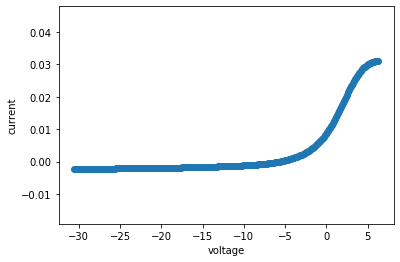

In [35]:
# ds.current.plot.line()
ds.plot.scatter(x='voltage', y='current')

## Calculate Floating Potential

In [36]:
ds.plasmapy.swept_langmuir.find_floating_potential()
ds.floating_potential_fit.sel(vf_fit_params='indices',
                              vf_fit_values='value').data
ds

<xarray.Dataset>
Dimensions:                 (time_index: 304, vf: 2, vf_fit_params: 3, vf_fit_values: 2)
Coordinates:
  * vf                      (vf) <U5 'value' 'err'
  * vf_fit_params           (vf_fit_params) <U9 'slope' 'intercept' 'indices'
  * vf_fit_values           (vf_fit_values) <U5 'value' 'error'
Dimensions without coordinates: time_index
Data variables:
    voltage                 (time_index) float64 -30.57 -30.45 ... 6.165 6.287
    current                 (time_index) float64 -0.002315 -0.002311 ... 0.03104
    floating_potential      (vf) float64 -5.73 0.08753
    floating_potential_fit  (vf_fit_params, vf_fit_values) object 0.0004886 ... nan
Attributes:
    probe_parameters:  <__main__.LangmuirProbe object at 0x134cf0990>

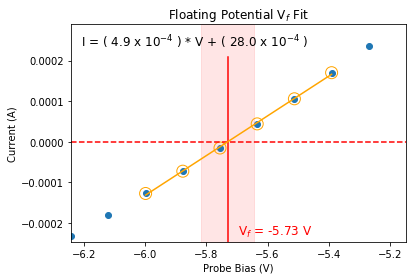

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1360c6ad0>)

In [37]:
ds.plasmapy.swept_langmuir.plot_floating_potential_fit()

In [46]:
ds.voltage.attrs['units'] = u.V
ds.plasmapy

In [26]:
results = find_floating_potential(bias, current)
type(results[0])


numpy.float64

----
----

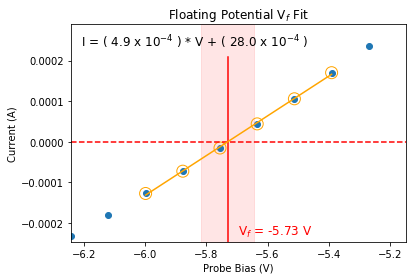

In [904]:
fig, ax = plt.subplots()
        
# get data subset
sub = ds.floating_potential_fit.sel(vf_fit_params='indices',
                                    vf_fit_values='value')
Vsub = ds.voltage[sub].data
Isub = ds.current[sub].data

# generate fit curve
a = ds.floating_potential_fit.sel(vf_fit_params='slope', 
                                  vf_fit_values='value').data[()]
b = ds.floating_potential_fit.sel(vf_fit_params='intercept', 
                                  vf_fit_values='value').data[()]
Isub_fit = a * Vsub + b

#
vf = ds.floating_potential.sel(vf='value').data[()]
vf_err = ds.floating_potential.sel(vf='err').data[()]

# calc plot limits
xpad = 0.4 * np.abs(Vsub.max() - Vsub.min())
ypad = 0.4 * np.abs(Isub.max() - Isub.min())
xlim = [Vsub.min() - xpad, Vsub.max() + xpad]
ylim = [Isub.min() - ypad, Isub.max() + ypad]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('Probe Bias (V)')
ax.set_ylabel('Current (A)')
ax.set_title('Floating Potential V$_f$ Fit')

# add plot elemnts
ax.plot(ax.get_xlim(), [0.0, 0.0], 'r--', label='I = 0')
ystop = ax.transData.inverted().transform(ax.transAxes.transform([0.0, 0.85]))[1]
ax.plot([vf, vf], 
        [ylim[0], ystop],
        'r', 
        label='vf')
ax.fill_between([vf - vf_err, vf + vf_err], 
                ylim[0],
                ylim[1],
                color='r', alpha=0.1)
ax.plot(Vsub, Isub_fit, label='fit', color='orange')
ax.scatter(ds['voltage'], ds['current'], label='data')
ax.scatter(Vsub, Isub, 
           s=12**2, 
           label='fit data', 
           facecolors='none', 
           edgecolors='orange')

# labels
txt = f"V$_f$ = {vf.data[()]:.2f} V"
txt_loc = [vf, ylim[0]]
txt_loc = ax.transAxes.inverted().transform(ax.transData.transform(txt_loc))
txt_loc[1] = 0
txt_loc += 0.03
ax.text(txt_loc[0], txt_loc[1], txt, color='r', fontsize='large', transform=ax.transAxes)

vals = [a, b]
imax = np.abs(np.log10(vals)).argmax()
power = np.log10(vals[imax])
power = int(np.sign(power)) * int(np.ceil(np.abs(power)))
txt = (f"I = ( {a * (10 ** -power):.1f} x 10$^{{{power}}}$ ) * V "
       f"+ ( {b * (10 ** -power):.1f} x 10$^{{{power}}}$ )")
txt_loc = [0.0 + 0.03, 1.0 - 0.1]
ax.text(txt_loc[0], txt_loc[1], txt, color='black', fontsize='large', transform=ax.transAxes)

plt.show()

In [891]:
txt

'I = (4.9 x 10$^-4$) * V + (28.0)'

In [884]:
vals = [a, b]
imax = np.abs(np.log10(vals)).argmax()
power = np.log10(vals[imax])
power = int(np.sign(power)) * int(np.ceil(np.abs(power)))
power

-4

## Calculate Plasma Potential

In [416]:
def calc_plasma_potential(voltage, current, method='didv_maximal_fit'):
    return calc_plasma_potential_didv_maximal_fit(voltage, current)

def calc_plasma_potential_didv_maximal_fit(voltage, current):
    didv = np.gradient(current, voltage)
    return didv

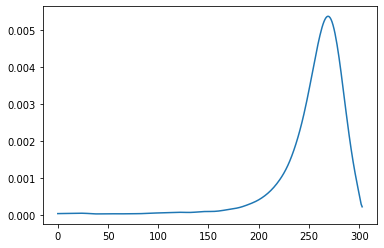

In [417]:
results = calc_plasma_potential(bias, current)
plt.plot(results)

## Calculate Ion-Saturation Current

In [379]:
def calc_ion_saturation_current(voltage, curent):
    lower_vals = np.where(current <= 0, True, False)
    if np.count_nonzero(lower_vals) == 0:
        warn('Sweep has no ion-saturation current')
        return np.nan
    
    def model(x, a, r, c):
        return (a * (r ** x)) + c
    
    diffs = -np.diff(np.flip(current[lower_vals]))
    xdata = np.arange(diffs.size)
    popt, pcov = scipy.optimize.curve_fit(model, xdata, diffs, p0=[1., 0.2, 0.1])
    
    theta0 = diffs[0] + ((popt[0] * popt[1]) / (1 - popt[1]))
    
    return popt, pcov, theta0

In [384]:
results = calc_ion_saturation_current(bias, current)
results
theta0 = results[2]
alpha = -results[0][2]
(alpha, theta0)

(-4.876936487328768e-06, 0.001311489977513252)

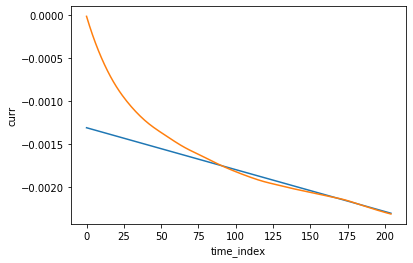

In [391]:
lower_vals = np.where(current <= 0, True, False)
np.diff(current[lower_vals])
dss = xr.Dataset({
    'curr': xr.DataArray(np.flip(current[lower_vals]), dims=['time_index']),
    'volt': xr.DataArray(np.flip(bias[lower_vals]), dims=['time_index']),
})
dss['diff'] = xr.DataArray(np.diff(dss['curr']))
dss['curr_fit'] = xr.DataArray((alpha * dss['time_index'] - theta0))


dss['curr_fit'].plot.line()
dss['curr'].plot.line()

In [299]:
ds.plasmapy.swept_langmuir.analyze()
ds

<xarray.Dataset>
Dimensions:                 (time_index: 304)
Dimensions without coordinates: time_index
Data variables:
    voltage                 (time_index) float64 -30.57 -30.45 ... 6.165 6.287
    current                 (time_index) float64 -0.002315 -0.002311 ... 0.03104
    floating_potential      float64 -5.73
    floating_potential_err  float64 0.08753

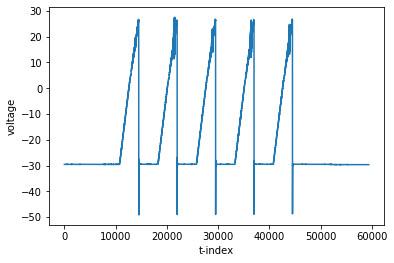

In [87]:
ds['voltage'].plot.line()

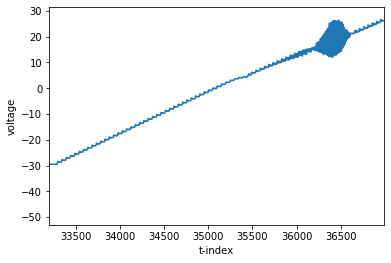

In [99]:
ds['voltage'].plot.line(xlim=ds['trace-window'][0,:] + (3 * 7500))

# Temporal Plot of 1st Voltage Sweep

Text(0.5, 0, 'Time (ms)')

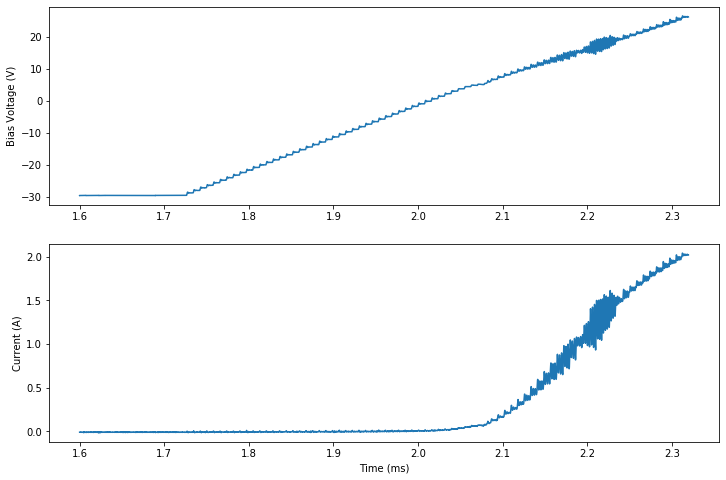

In [27]:
# find temporal window
start = 10000
end = 15000
ds = np.s_[start:end]
minV_i = np.argmin(vsweep[ds])
end = start + minV_i - 12
ds = np.s_[start:end]

# build temporal array
time = np.arange(start, end, 1, dtype=np.float64) * dt

# plot
fig = plt.figure(1, figsize = (12, 8))
#ax = fig.add_subplot(111, frameon=False)
axV = fig.add_subplot(211)
axI = fig.add_subplot(212)

axV.plot(time, vsweep[ds])
axV.set_ylabel('Bias Voltage (V)')

axI.plot(time, isweep[ds])
axI.set_ylabel('Current (A)')
axI.set_xlabel('Time (ms)')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


Text(0.5, 0, 'Bias Voltage (V)')

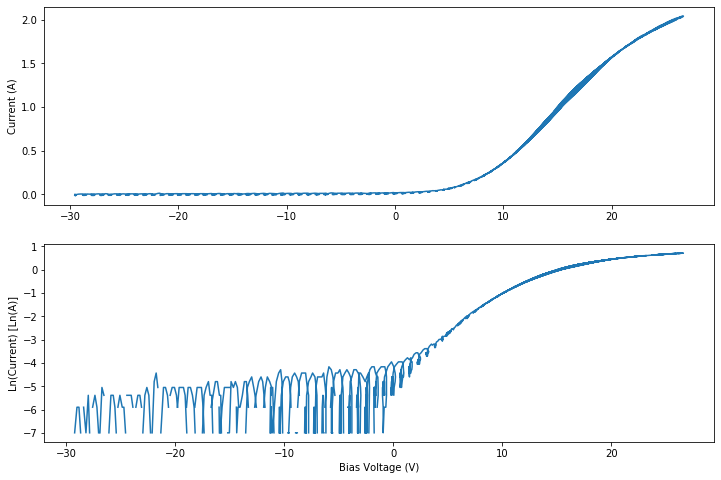

In [28]:
iv_fig = plt.figure(figsize=(12, 8))
axIV = iv_fig.add_subplot(211)
axlogIV = iv_fig.add_subplot(212)

axIV.plot(vsweep[ds], isweep[ds])
axIV.set_ylabel('Current (A)')

axlogIV.plot(vsweep[ds], np.log(isweep[ds]))
axlogIV.set_ylabel('Ln(Current) [Ln(A)]')
axlogIV.set_xlabel('Bias Voltage (V)')

# Analyze

## Calculate Isat

In [42]:
VV = vsweep[ds]
II = isweep[ds]

# sort arrays s.t. voltage is ascending
VVsorti = np.argsort(VV)
VV = VV[VVsorti]
II = II[VVsorti]

Isat_mask = np.where(VV < -20.0, True, False)
Isat = np.mean(II[Isat_mask])
Isat_std = np.std(II[Isat_mask])

print("Isat: {0:.4f} +/- {1:0.4f} A".format(Isat, Isat_std))

Isat: -0.0077 +/- 0.0030 A


Text(0.5, 0, 'Bias Voltage (V)')

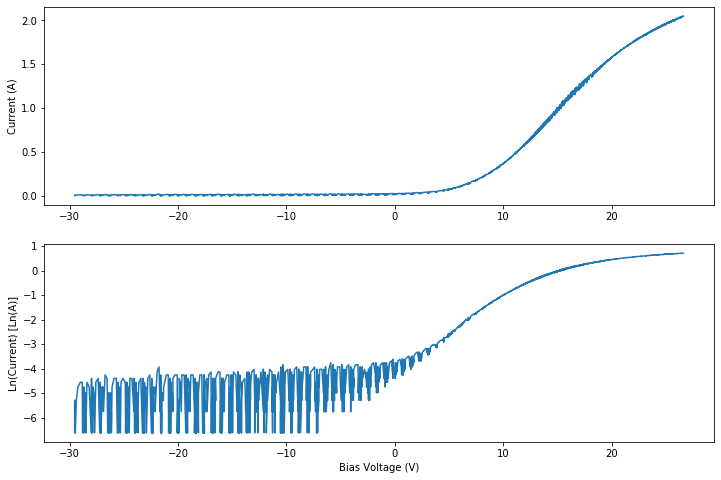

In [30]:
iv_fig = plt.figure(figsize=(12, 8))
axIV = iv_fig.add_subplot(211)
axlogIV = iv_fig.add_subplot(212)

IIadj = II - Isat
ii_mask = np.where(IIadj <= 0.0, False, True)

axIV.plot(VV[ii_mask], IIadj[ii_mask])
axIV.set_ylabel('Current (A)')


axlogIV.plot(VV[ii_mask], np.log(IIadj[ii_mask]))
axlogIV.set_ylabel('Ln(Current) [Ln(A)]')
axlogIV.set_xlabel('Bias Voltage (V)')

# Probablility of Linearity

In [31]:
# filter out negative IIadj
mask = np.where(IIadj <= 0.0, False, True)
IIadj = IIadj[mask]
VV = VV[mask]
lnIIadj = np.log(IIadj)

# find min and max voltage in sweep
minV = min(VV)
maxV = max(VV)

# define fitting voltage window sizes and voltage steps
dVs = dVs_percent * (maxV - minV)
Vstep = Vstep_percent * (maxV - minV)
NVsteps = int(np.ceil(1.0 / Vstep_percent))

# iniitialize fit data array
dtype = np.dtype([
    ('dV', np.float32),
    ('fit', [('Vi', np.float), 
             ('NSamples', np.int32), 
             ('slope', np.float64),
             ('b', np.float64),
             ('rsq', np.float64),
             ('slope_err', np.float64)], NVsteps)
])
fitd = np.empty(len(dVs), dtype=dtype)

In [32]:
# calculated fits
for ii, dV in enumerate(dVs):
    fitd[ii]['dV'] = dV
    
    for jj in range(NVsteps):
        start = minV + (float(jj) * Vstep)
        end = start + dV
        mask1 = np.where(start <= VV, True, False)
        mask2 = np.where(VV < end, True, False)
        mask = np.logical_and(mask1, mask2)
        ii_max = max(np.nonzero(mask)[0])
        
        # get subset of voltage and current
        Vsub = VV[mask]
        Isub = lnIIadj[mask]
        
        if (( max(Vsub) - min(Vsub) ) <= ( 0.95 * dV )) and (ii_max == (len(VV) - 1)):
            fitd[ii]['fit'][jj]['Vi'] = np.nan
            fitd[ii]['fit'][jj]['NSamples'] = -1
            fitd[ii]['fit'][jj]['slope'] = np.nan
            fitd[ii]['fit'][jj]['b'] = np.nan
            fitd[ii]['fit'][jj]['rsq'] = np.nan
            fitd[ii]['fit'][jj]['slope_err'] = np.nan
        else:
            # assign values to array
            fitd[ii]['fit'][jj]['Vi'] = np.mean(Vsub)
            fitd[ii]['fit'][jj]['NSamples'] = Vsub.size

            # calc fig
            #fit = np.polyfit(Vsub, Isub, 1)
            fit = scipy.stats.linregress(Vsub, Isub)  # slope, intercept, rvalue, pvalue, stderr (of gradient)
            fitd[ii]['fit'][jj]['slope'] = fit[0]
            fitd[ii]['fit'][jj]['b'] = fit[1]
            fitd[ii]['fit'][jj]['rsq'] = fit[2] ** 2
            fitd[ii]['fit'][jj]['slope_err'] = fit[4]

In [33]:
# let's contour plot Vi (x), dV (y), rsq (z)
#
# generate x, y, z

2.8062625


(0.9, 1.1)

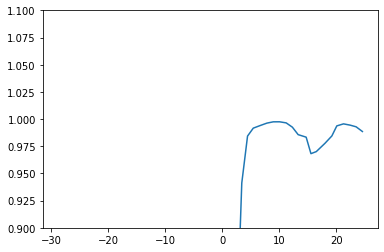

In [34]:
dVi = 0
print(fitd[dVi]['dV'])
#plt.plot(fitd[dVi]['fit']['Vi'], fitd[dVi]['fit']['slope_err']/fitd[dVi]['fit']['slope'])
#plt.plot(fitd[dVi]['fit']['Vi'], fitd[dVi]['fit']['slope'])
plt.plot(fitd[dVi]['fit']['Vi'], fitd[dVi]['fit']['rsq'])
plt.ylim((0.9, 1.1))

In [35]:
# x-axis = voltage
# y-axis = step size
# z-axis= slope or rsq
xx = np.empty((NVsteps, len(dVs)), dtype=np.float64)
yy = np.empty((NVsteps, len(dVs)), dtype=np.float64)
zz_slope = np.empty((NVsteps, len(dVs)), dtype=np.float64)
zz_rsq = np.empty((NVsteps, len(dVs)), dtype=np.float64)

for jj in range(len(dVs)):
    yy[..., jj] = fitd[jj]['dV']
    
    for ii in range(NVsteps):
        xx[ii, jj] = fitd[jj]['fit'][ii]['Vi']
        if np.isnan(xx[ii, jj]):
            xx[ii, jj] = 0.
        zz_slope[ii, jj] = fitd[jj]['fit'][ii]['slope']
        zz_rsq[ii, jj] = fitd[jj]['fit'][ii]['rsq']

In [36]:
print(xx.shape, yy.shape, zz_slope.shape)
print(np.nanmin(xx), np.nanmax(xx))
print(np.nanmin(yy), np.nanmax(yy))
print(np.nanmin(zz_slope), np.nanmax(zz_slope))
print(np.nanmin(zz_rsq), np.nanmax(zz_rsq))

(50, 21) (50, 21) (50, 21)
-28.832424289987014 24.575351127881937
2.806262493133545 26.940120697021484
-0.11056475032586874 0.37567438611546783
4.99642154855523e-05 0.997498271920925


Text(-45, 40, '$r^{2}_{MAX} = $0.997')

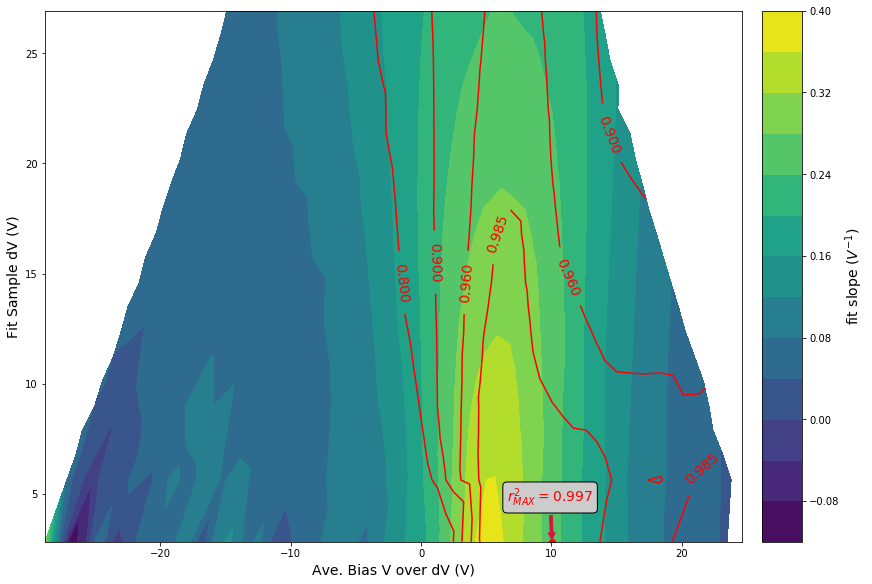

In [37]:
cfig, cax = plt.subplots(constrained_layout=True, figsize=(12, 8))
CP_slope = cax.contourf(xx, yy, zz_slope, 12)
CP_rsq = cax.contour(xx, yy, zz_rsq, levels=[0.8, 0.9, 0.96, 0.985], colors='r')

cax.set_xlabel('Ave. Bias V over dV (V)', fontsize=14)
cax.set_ylabel('Fit Sample dV (V)', fontsize=14)
cax.clabel(CP_rsq, fmt='%5.3f', colors='r', fontsize=14)

cbar = cfig.colorbar(CP_slope)
cbar.ax.set_ylabel('fit slope ($V^{-1}$)', fontsize=14)

# ger max rsq
rsq_max = np.nanmax(zz_rsq)
iloc = np.where(zz_rsq == rsq_max)
ii_rsq_max = iloc[0][0]
jj_rsq_max = iloc[1][0]
x_rsq_max = xx[ii_rsq_max, jj_rsq_max]
y_rsq_max = yy[ii_rsq_max, jj_rsq_max]
CP_rsq_max = cax.plot(x_rsq_max, y_rsq_max, 'ro', color='r')

# label/plot MAX rsq value
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "simple",
    color='crimson')

txt = "$r^{2}_{MAX} = $" + "{0:5.3f}".format(rsq_max)
xy = (x_rsq_max, y_rsq_max)
cax.annotate(txt, xy, xytext=(-45, 40), textcoords='offset points', 
             bbox=bbox, arrowprops=arrowprops, color='r', fontsize=14)

# Calculate Electron Temp.

In [38]:
nan_mask = np.logical_not(np.isnan(zz_rsq))
ineq_mask = np.where(zz_rsq >= 0.985, True, False)
fit_mask = np.logical_and(nan_mask, ineq_mask)

dV_max = np.nanmax(yy[fit_mask])

jj = np.where(yy[0, ...] == dV_max)[0][0]
iis = np.where(zz_rsq[..., jj] >= 0.985)[0]
slope = np.mean(zz_slope[iis, jj]) / astropy.units.Volt  # 1/V
#print(iis, jj, dV_max, slope)
print("V = {0:.3f}, dV = {1:0.3f}, slope = {2:0.3f}".format(np.mean(xx[iis,jj]), 
                                                            np.mean(yy[iis,jj]), 
                                                            slope))

V = 6.715, dV = 17.960, slope = 0.283 1 / V


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


In [39]:
#slope = 0.32 / astropy.units.Volt  # 1/V
Te = e.si / (k_B * slope).si
Te = Te.to(astropy.units.eV, equivalencies=astropy.units.temperature_energy())
print("Te = {0:.3f}".format(Te))

Te = 3.529 eV


In [40]:
import bapsflib.plasma.parameters as params
params.cyclotron_frequency()

ModuleNotFoundError: No module named 'bapsflib.plasma.parameters'